A short introduction to fast SPT modeling
-----------------------------------------

This notebook presents a short introduction to the modeling of fast single particle tracking datasets. 
The methodology, together with examples of biological relevance, can be found at:

> Hansen, Anders S., Iryna Pustova, Claudia Cattoglio, Robert Tjian, and Xavier Darzacq. “CTCF and Cohesin Regulate Chromatin Loop Stability with Distinct Dynamics.” bioRxiv, 2016, 093476.

This package includes several sample datasets, that will be used by this notebook. Make sure that they can be found by Python.

## 1. Loading of a dataset

To help us with basic and repeated tasks such as dataset loading, we created a small library, `fastSPT_tools` that contain several helper functions that we will use all across this tutorial. We thus need to import it by typing `import fastSPT_tools`.

One of the functions list the available datasets: `list_sample_datasets(path)`. Let's first see what datasets we can get. Then, we will use the `load_dataset(path, dataset_id, cells)` function to load the relevant dataset. This latter function can either load one single cell or a series of cells (identified by their id).

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import fastspt
import fastspt.fastSPT_tools as fastSPT_tools
import fastspt.fastSPT_plot as fastSPT_plot
reload(fastspt)
reload(fastSPT_tools)
reload(fastSPT_plot)

print fastSPT_tools.list_sample_datasets(path="./datasets/")

Found 2 datasets

-- Dataset 0: SampleName (path /Users/AndersSejrHansen/Dropbox/MatLab/Lab/Microscopy/SingleParticleTracking/Analysis/FastTrackingData/20160216_C87_Halo-mCTCF_5nM_PA-JF549_FastTracking/)
Description: 20160216_C87_Halo-mCTCF_5nM_PA-JF549_FastTracking: 5 ms camera, 1 ms 561 nm, 6.75 ms per frame.

  Cell 0: NOT FOUND 20160216_5ms_PA-JF549_Pulse1_L100_Constant405-1.mat
  Cell 1: NOT FOUND 20160216_5ms_PA-JF549_Pulse1_L100_Constant405-2.mat

-- Dataset 1: 20160526 mESC C87 Halo-mCTCF 25 nM PA-JF646 (path ./20160526_mESC_C87_Halo-mCTCF_25nM_PA-JF646/)
Description: 20160526_mESC_C87_Halo-mCTCF_25nM_PA-JF646

  Cell 0: FOUND 20160526_mESC_C87_Halo-mCTCF_25nM_PA-JF646_1ms633_3-405_4msCam_cell1.rpt_tracked_TrackedParticles.mat
  Cell 1: FOUND 20160526_mESC_C87_Halo-mCTCF_25nM_PA-JF646_1ms633_3-405_4msCam_cell2.rpt_tracked_TrackedParticles.mat
  Cell 2: FOUND 20160526_mESC_C87_Halo-mCTCF_25nM_PA-JF646_1ms633_3-405_4msCam_cell3.rpt_tracked_TrackedParticles.mat
  Cell 3: FOUND 201

In [5]:
cell0   = fastSPT_tools.load_dataset("./datasets/", 1, 0) ## Load a single cell of dataset 1
cell1   = fastSPT_tools.load_dataset("./datasets/", 1, 1) ## Load a single cell of dataset 1
cellall = fastSPT_tools.load_dataset("./datasets/", 1, [0,1,2,3,4,5,6,7]) ## Load all the cells of dataset 1

## 2. Computation of the jump lengths distribution

In [6]:
CDF=True

h1 = fastspt.compute_jump_length_distribution(cell0, CDF=CDF, useAllTraj=True)

HistVecJumps = h1[2]
JumpProb = h1[3]
HistVecJumpsCDF = h1[0]
JumpProbCDF = h1[1]


print "Computation of jump lengths performed in {:.2f}s".format(h1[-1]['time'])

Number of frames: 20000.0, number of localizations: 9383
Computation of jump lengths performed in 2.54s


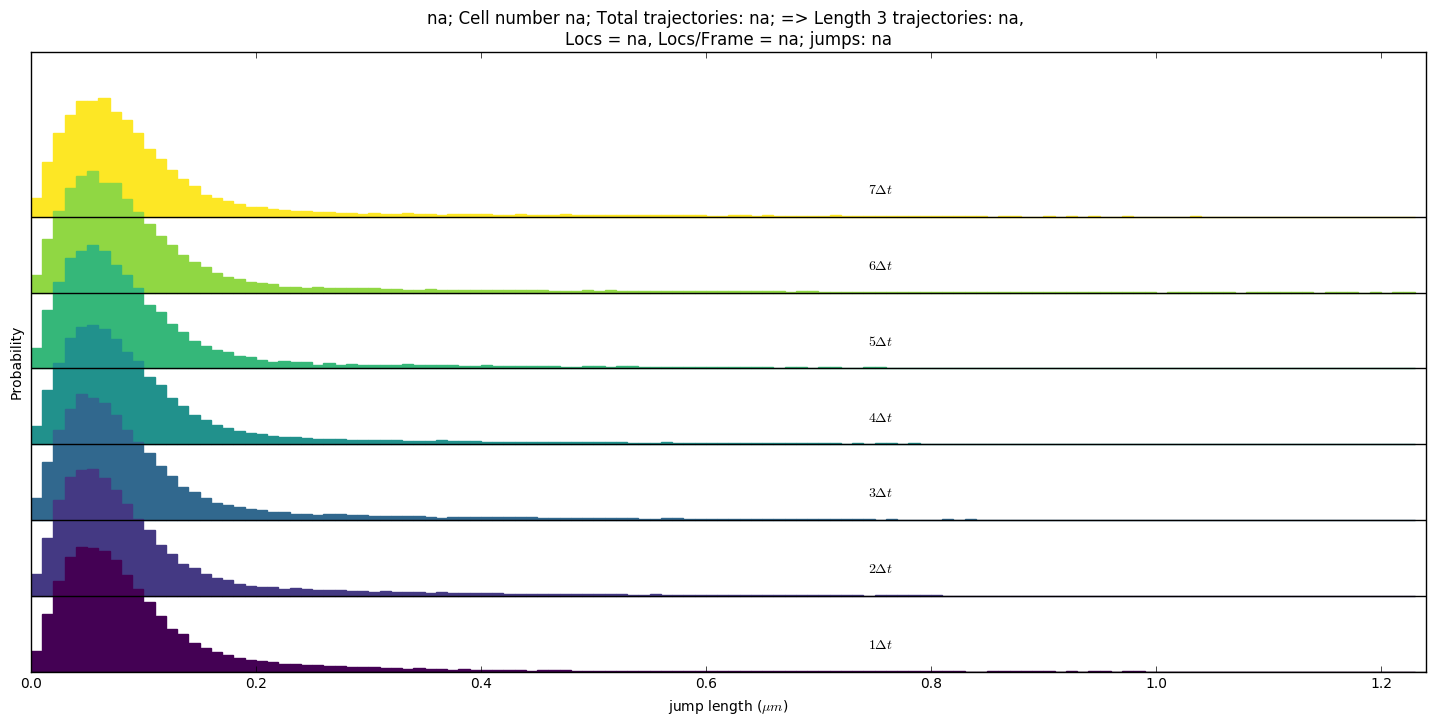

In [135]:
# Initialize the plot
plt.figure(figsize=(18,8))
fastSPT_plot.plot_histogram(HistVecJumps, JumpProb) ## Read the documentation of this function to learn how to populate all the 'na' fields

## 3. Fitting of the jump lengths distribution to the model

In [112]:
reload(fastSPT)

## Generate a dictionary of parameters
params = {'D_Free': [0.15, 25], 
          'D_Bound': [0.0005, 0.08], 
          'Frac_Bound': [0, 1],
          'LocError': 0.035, # Manually input the localization error in um: 35 nm = 0.035 um.
          'iterations': 3, # Manually input the desired number of fitting iterations:
          'dT': 4.477/1000, # Time between frames in seconds
          'dZ': 0.700, # The axial illumination slice: measured to be roughly 700 nm
          'ModelFit': [1,2][not CDF]
}

## Perform the fit
fit = fastspt.fit_jump_length_distribution(JumpProb, JumpProbCDF, HistVecJumps, HistVecJumpsCDF, **params)

Improved fit on iteration 1
Improved error is 3.03273706748e-06
Name        Value      Min      Max   Stderr
D_bound   0.01308   0.0005     0.08 0.0004433
D_free      1.076     0.15       25  0.04084
F_bound    0.8197        0        1 0.002762
None
Improved fit on iteration 2
Improved error is 3.03218690446e-06
Name        Value      Min      Max   Stderr
D_bound   0.01317   0.0005     0.08 0.0004428
D_free      1.087     0.15       25  0.04138
F_bound    0.8205        0        1 0.002749
None


The result of the fit has been stored in the `fit` variable. We can now plot the fitted results overlaid with the empirical distribution.

In [117]:
reload(fastSPT)

## Generate the PDF corresponding to the fitted parameters
y = fastspt.generate_jump_length_distribution(fit.params['D_free'], fit.params['D_bound'], fit.params['F_bound'], 
                                JumpProb, HistVecJumpsCDF,
                                params['LocError'], params['dT'], params['dZ'])
## Normalize it
norm_y = np.zeros_like(y)
for i in range(y.shape[0]): # Normalize y as a PDF
    norm_y[i,:] = y[i,:]/y[i,:].sum()
scaled_y = (float(len(HistVecJumpsCDF))/len(HistVecJumps))*norm_y #scale y for plotting next to histograms

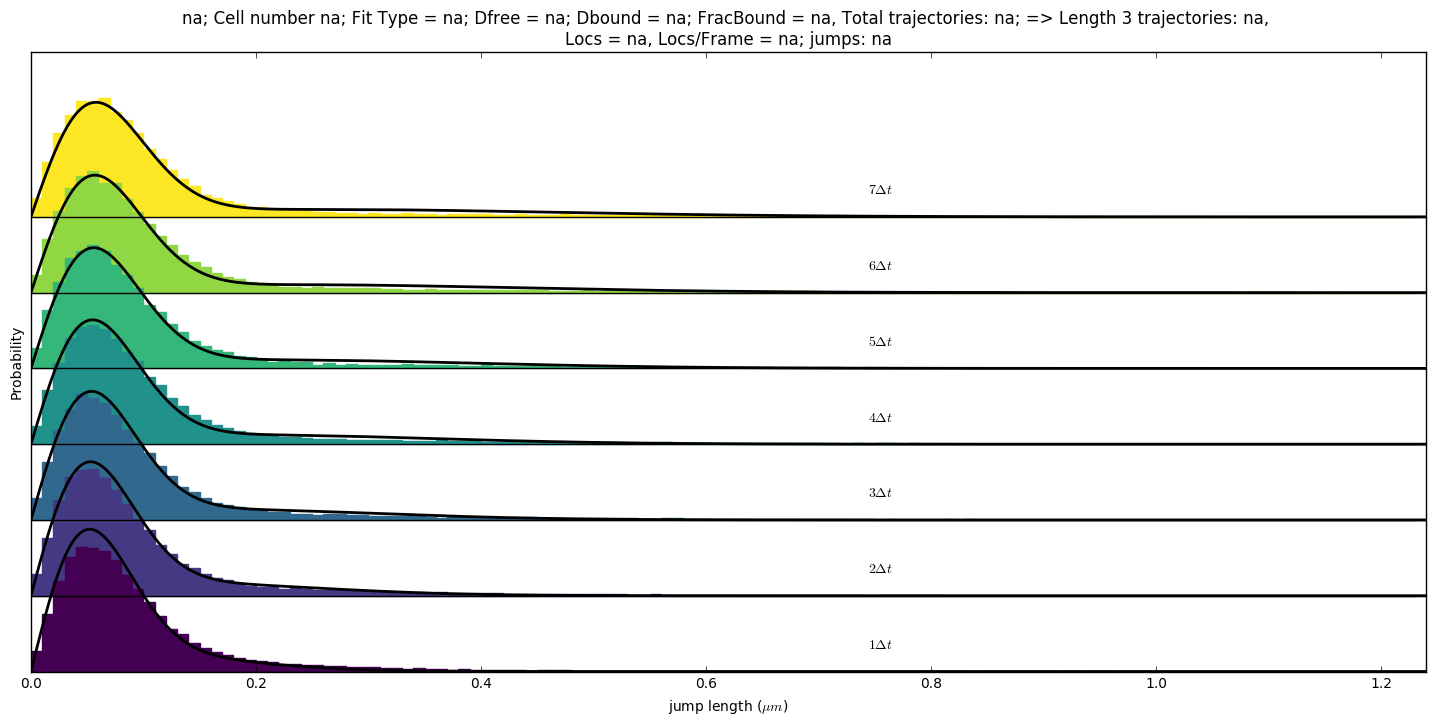

In [133]:
## And perform the plot
reload(fastSPT_plot)

plt.figure(figsize=(18,8)) # Initialize the plot
fastSPT_plot.plot_histogram(HistVecJumps, JumpProb, HistVecJumpsCDF, scaled_y) ## Read the documentation of this function to learn how to populate all the 'na' fields